# Predict the Payment

The idea of this project is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not.

In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

### Task 1: Identify Features

We sampled 20,000 rows each from general and research datasets for 2 years. The reason why we sample equally is, it is better to use the original data when available, rather than sample unequally and use synthetic balancing techniques later.

In [2]:
%%capture

filename = "PGYR17_P011819\\OP_DTL_GNRL_PGYR2017_P01182019.csv"
n_gnrl_2017 = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 20000 #desired sample size
skip = sorted(random.sample(range(1,n_gnrl_2017+1),n_gnrl_2017-s)) #the 0-indexed header will not be included in the skip list
general_2017 = pd.read_csv(filename, skiprows=skip)

In [3]:
%%capture

filename = "PGYR17_P011819\\OP_DTL_RSRCH_PGYR2017_P01182019.csv"
n_rsrch_2017 = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 20000 #desired sample size
skip = sorted(random.sample(range(1,n_rsrch_2017+1),n_rsrch_2017-s)) #the 0-indexed header will not be included in the skip list
research_2017 = pd.read_csv(filename, skiprows=skip)

**Sample Properties** The sample properties are as follows:

In [4]:
print("-------------------------------2017-------------------------------")
print("The number of rows in general_2017 is,",n_gnrl_2017,"We sampled",general_2017.shape[0],"of them")
print("The number of rows in research_2017 is,",n_rsrch_2017,"We sampled",research_2017.shape[0],"of them")

-------------------------------2017-------------------------------
The number of rows in general_2017 is, 10663833 We sampled 20000 of them
The number of rows in research_2017 is, 602530 We sampled 20000 of them


In [5]:
print("-------------------------------2017-------------------------------")
print("The number of attributes for general_2017 is",general_2017.shape[1])
print("The number of attributes for research_2017 is",research_2017.shape[1])

-------------------------------2017-------------------------------
The number of attributes for general_2017 is 75
The number of attributes for research_2017 is 176


To create a dataset to work with, we choose only the columns that are common to both types, general and research.

### 1.1. Union

Let's filter with respect to common attributes.

In [6]:
union=[]
for name in list(research_2017):
    if name in list(general_2017):
        union.append(name)
print("The common attributes are:")
union

The common attributes are:


['Change_Type',
 'Covered_Recipient_Type',
 'Teaching_Hospital_CCN',
 'Teaching_Hospital_ID',
 'Teaching_Hospital_Name',
 'Physician_Profile_ID',
 'Physician_First_Name',
 'Physician_Middle_Name',
 'Physician_Last_Name',
 'Physician_Name_Suffix',
 'Recipient_Primary_Business_Street_Address_Line1',
 'Recipient_Primary_Business_Street_Address_Line2',
 'Recipient_City',
 'Recipient_State',
 'Recipient_Zip_Code',
 'Recipient_Country',
 'Recipient_Province',
 'Recipient_Postal_Code',
 'Physician_Primary_Type',
 'Physician_Specialty',
 'Physician_License_State_code1',
 'Physician_License_State_code2',
 'Physician_License_State_code3',
 'Physician_License_State_code4',
 'Physician_License_State_code5',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Applicable_Manufacturer_or_Applica

Let's concatenate the research and general data.

In [57]:
%%capture

# general = [general_2017,general_2016]
# research = [research_2017,research_2016]
general = [general_2017]
research = [research_2017]
general = pd.concat(general)
research = pd.concat(research)

general_filtered = general[union]
general_filtered['target'] = 0

research_filtered = research[union]
research_filtered['target'] = 1

frames = [general_filtered,research_filtered]
data = pd.concat(frames)

### 1.2. Missing Values

Let's look at the missing values, if there are many we might have to discard the column. The threshold value we select for missing values is 47 percent.

In [58]:
print("The percentage of missing values are as follows:")
missing_values = dict(data.isna().sum().sort_values(ascending=False)/data.shape[0])
print(data.isna().sum().sort_values(ascending=False)/data.shape[0])

The percentage of missing values are as follows:
Physician_License_State_code5                                       0.999900
Recipient_Province                                                  0.999625
Physician_License_State_code4                                       0.999600
Recipient_Postal_Code                                               0.999450
Associated_Drug_or_Biological_NDC_5                                 0.998550
Physician_License_State_code3                                       0.997925
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5           0.995025
Product_Category_or_Therapeutic_Area_5                              0.995025
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5            0.994950
Covered_or_Noncovered_Indicator_5                                   0.994925
Associated_Drug_or_Biological_NDC_4                                 0.991075
Physician_License_State_code2                                       0.989775
Product_Category_or_Therape

In [59]:
print("The following fields are removed as more than 50% of the data is missing in these fields")
list(missing_values.keys())[0:33]

The following fields are removed as more than 50% of the data is missing in these fields


['Physician_License_State_code5',
 'Recipient_Province',
 'Physician_License_State_code4',
 'Recipient_Postal_Code',
 'Associated_Drug_or_Biological_NDC_5',
 'Physician_License_State_code3',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5',
 'Product_Category_or_Therapeutic_Area_5',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5',
 'Covered_or_Noncovered_Indicator_5',
 'Associated_Drug_or_Biological_NDC_4',
 'Physician_License_State_code2',
 'Product_Category_or_Therapeutic_Area_4',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4',
 'Physician_Name_Suffix',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4',
 'Covered_or_Noncovered_Indicator_4',
 'Associated_Drug_or_Biological_NDC_3',
 'Product_Category_or_Therapeutic_Area_3',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3',
 'Covered_or_Noncovered_Indicator_3',
 'Teaching_Hospital_Name',
 'Teaching_Hospital_CCN',
 'Te

Let's remove the above variables from the dataframe.

In [60]:
for name in list(missing_values.keys())[0:33]:
    try:
        data = data.drop(labels = name,axis=1)
    except:
        continue

### 1.4 Visualization

We have encoded the class as 0 for general data and 1 for research data.

From the below plots, we can see that "Covered_Recipient_Type" is leaking information as it is very easy to tell if the target is 0 or 1 just by looking at the 3 categories of the Covered_Recipient_Type. 
"Physician_Profile_ID" is present majorly in general data rather than in research. This is potentially misleading and is an information leaking attribute as the model will learn that if this information is available then it is most likely to belong to general payment type. Moreover, fields like name, id, address are unique and they don't necessarily contribute in deciding what the target could be. Hence such fields are dropped.

Covered_Recipient_Type and Physician_Profile_ID


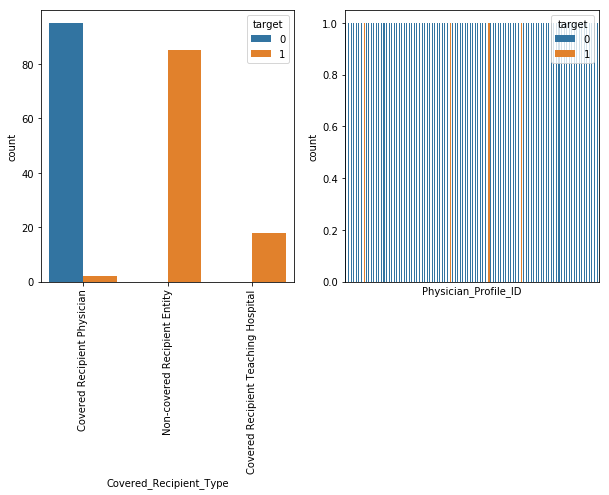

In [61]:
i=1
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())

"Physician_First_Name" and "Recipient_Primary_Business_Street_Address_Line1" are unique fields and don't hold any information about the target. Rather they tend to leak information. Given that those attributes exist the model can easily understand that it belongs to a general payment.

Physician_First_Name and Physician_Last_Name


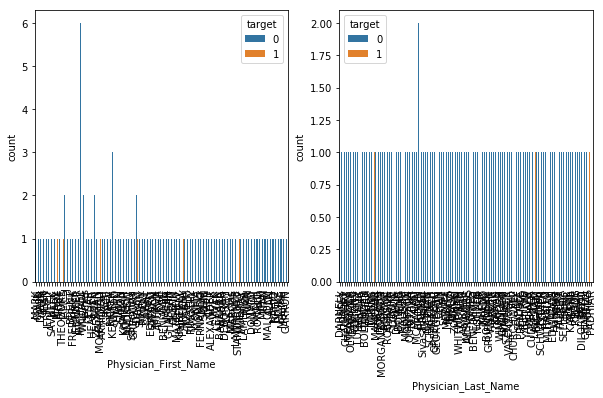

In [10]:
i=3
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

"Recipient_City" and "Recipient_Primary_Business_Street_Address_Line1" are not very informative as both categories have the same distribution.

Recipient_Primary_Business_Street_Address_Line1 and Recipient_City


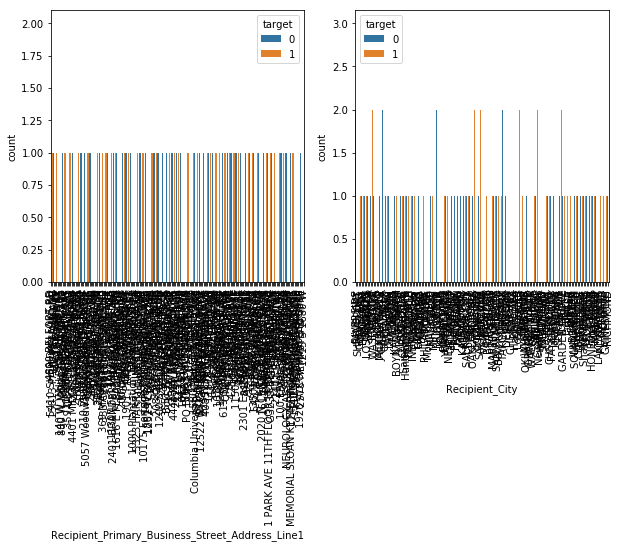

In [11]:
i=5
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

"Recipient_Zip_Code" is not very informative as both categories have the same distribution, so we remove it.However, "Recipient_State" is an important feature as the distributions are significant different.

Recipient_State and Recipient_Zip_Code


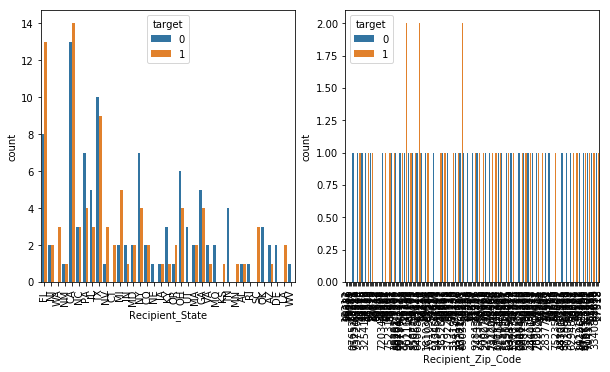

In [12]:
i=7
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

"Physician_Primary_Type" leaks information as given this field exists it is most likely to be a general payment. Thus, we will remove it. "Recipient_Country" is not very informative and hence we remove that as well.

Recipient_Country and Physician_Primary_Type


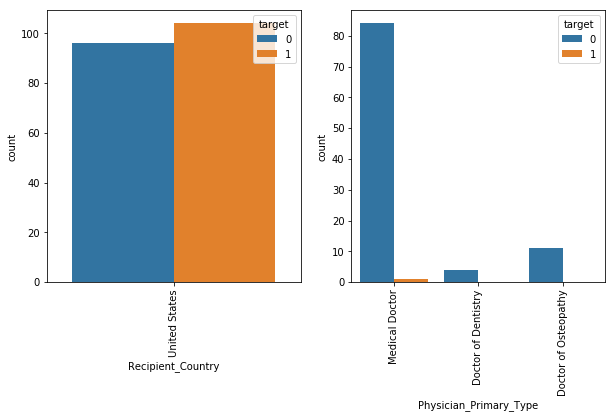

In [13]:
i=9
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

We will remove "Physician_License_State_code1"  as it leaks information about general payments. We will keep 
"Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name" as it contains distribution information regarding to both variables.

Physician_License_State_code1 and Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name


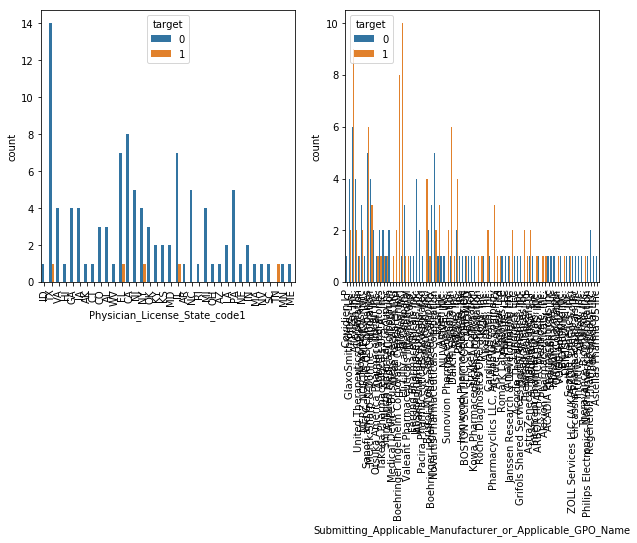

In [14]:
i=11
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

From Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID and Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name we will keep only one as clearly one denotes the other (id vs name).

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID and Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name


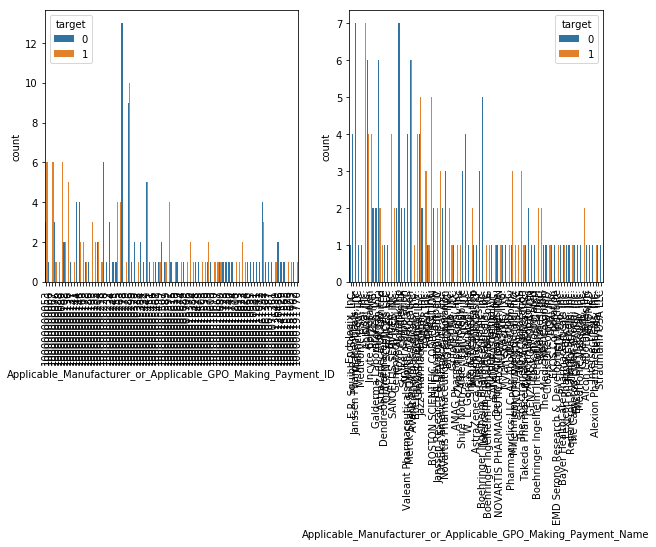

In [15]:
i=13
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

We will keep "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State" eventhough the distributions intersects as it provides nice informtion for states like Florida, Connecticut and Oregon etc. We will also keep "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country" as it gives an information that for certain states like MN,CT,MI etc it is most likely to be research payment.

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State and Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country


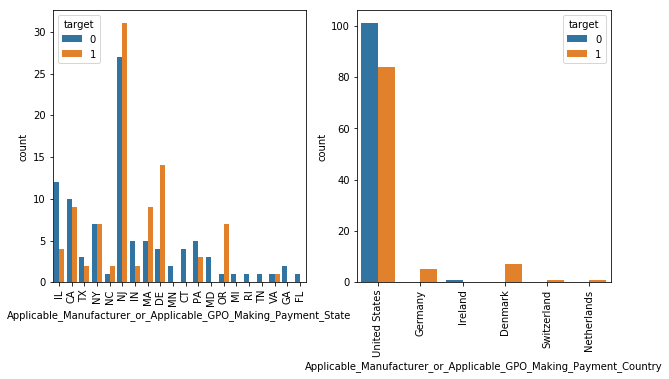

In [16]:
i=15
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

We will keep "Related_Product_Indicator" as P(research|No) is far higher than P(general|No). We will also keep "Covered_or_Noncovered_Indicator_1" as P(research|Non-covered) is 10 times more than P(general|Non-covered).

Related_Product_Indicator and Covered_or_Noncovered_Indicator_1


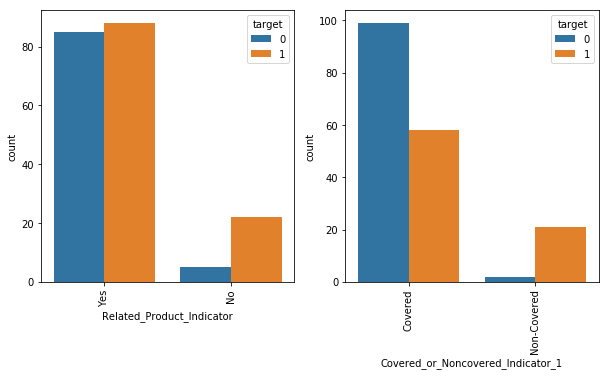

In [17]:
i=17
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

We will keep "Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1" as this field has really low missing values and combination of this attribute with others can result with meaningful patterns. Same is valid for "Product_Category_or_Therapeutic_Area_1".

Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 and Product_Category_or_Therapeutic_Area_1


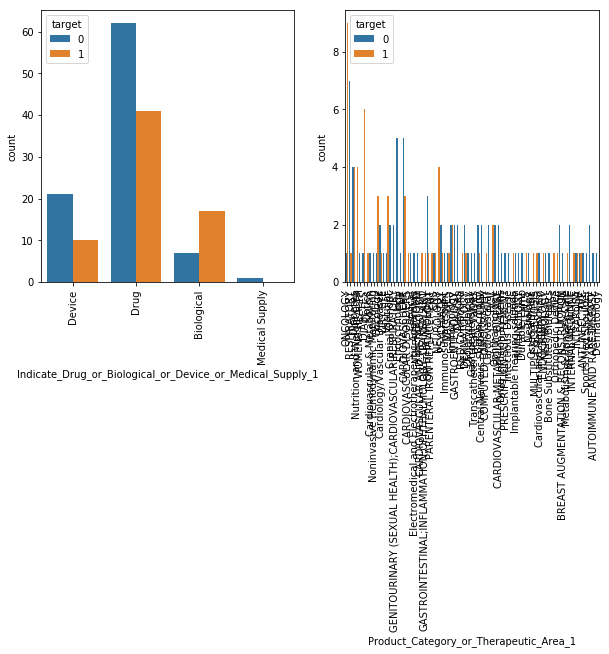

In [18]:
i=19
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

We will keep "Associated_Drug_or_Biological_NDC_1" and "Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1" as some drugs might be more likely to be used for reasearch than others.

Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1 and Associated_Drug_or_Biological_NDC_1


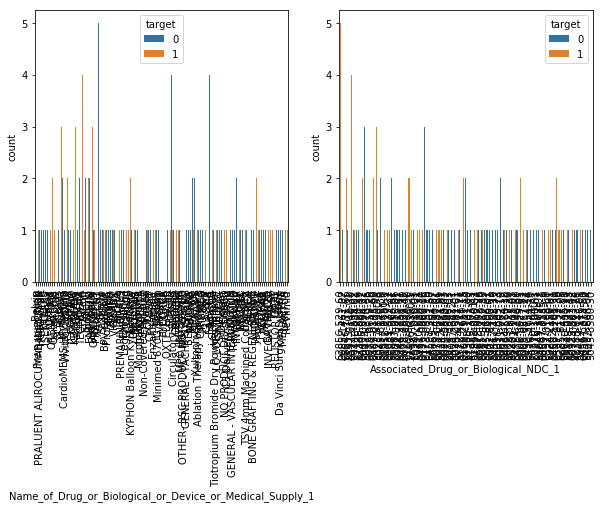

In [19]:
i=21
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

We will keep "Total_Amount_of_Payment_USDollars" as it can be seen that after a certain point the amount paid is more likely to be for a reaserach project. We will remove "Date_of_Payment" as the distribution does not give an information.

Total_Amount_of_Payment_USDollars and Date_of_Payment


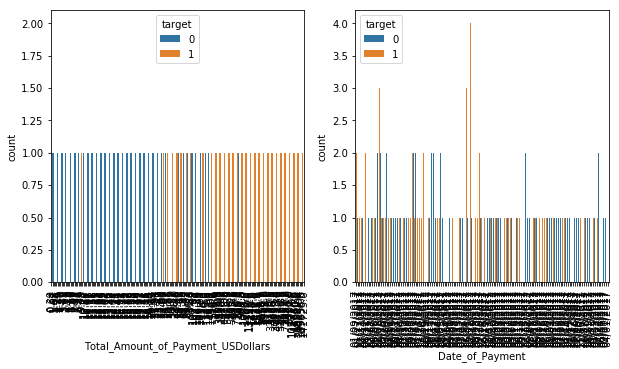

In [20]:
i=23
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

We will keep "Form_of_Payment_or_Transfer_of_Value" as it gives a nice information about the target. We will remove "Delay_in_Publication_Indicator" as it is not informative clearly.

Form_of_Payment_or_Transfer_of_Value and Delay_in_Publication_Indicator


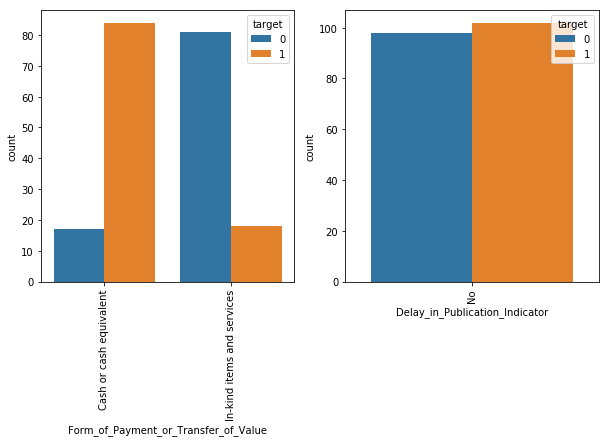

In [21]:
i=25
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

We will remove "Dispute_Status_for_Publication" and "Record_ID" as they don't provide information regarding to target.

Dispute_Status_for_Publication and Record_ID


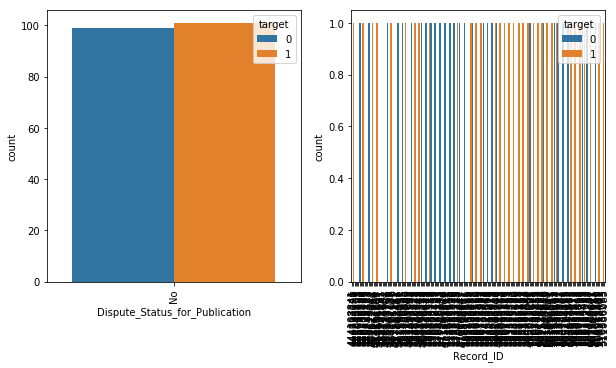

In [22]:
i=27
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

We will remove "Program_Year" and "Payment_Publication_Date" as they are not informative.

Program_Year and Payment_Publication_Date


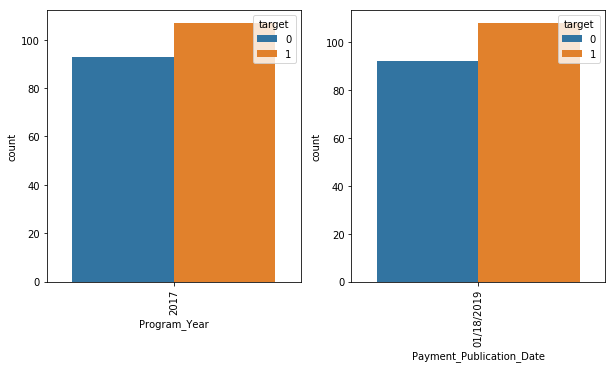

In [23]:
i=29
print(list(data)[i], "and", list(data)[i+1])
f, axes = plt.subplots(1,2, figsize = (10, 5));
plt.xticks(rotation=90);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i],ax = axes[0]);
sns.countplot(data=data.sample(n=200),hue="target",x=list(data)[i+1],ax = axes[1]);
for i in range(1):
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

To summarize, the features that are either leaking information or not informative are as follows. They are removed.

In [12]:
remove = ['Teaching_Hospital_ID','Physician_License_State_code2',
'Physician_License_State_code3',
'Physician_License_State_code4',
'Physician_License_State_code5',
'Covered_or_Noncovered_Indicator_2',
'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
'Product_Category_or_Therapeutic_Area_2',
'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2',
'Associated_Drug_or_Biological_NDC_2',
'Covered_or_Noncovered_Indicator_3',
'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3',
'Product_Category_or_Therapeutic_Area_3',
'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3',
'Associated_Drug_or_Biological_NDC_3',
'Covered_or_Noncovered_Indicator_4',
'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4',
'Product_Category_or_Therapeutic_Area_4',
'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4',
'Associated_Drug_or_Biological_NDC_4',
'Covered_or_Noncovered_Indicator_5',
'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5',
'Product_Category_or_Therapeutic_Area_5',
'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5',
'Associated_Drug_or_Biological_NDC_5','Change_Type',
'Teaching_Hospital_CCN',
'Teaching_Hospital_Name',
'Physician_First_Name',
'Physician_Middle_Name',
'Physician_Last_Name',
'Physician_Name_Suffix',
'Covered_Recipient_Type',
'Recipient_Primary_Business_Street_Address_Line1',
'Recipient_Primary_Business_Street_Address_Line2',
'Recipient_Zip_Code',
'Recipient_Province',
'Recipient_Postal_Code',
'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
"Delay_in_Publication_Indicator","Dispute_Status_for_Publication",
"Record_ID","Program_Year",
"Payment_Publication_Date","Recipient_City",
"Recipient_Country","Physician_Primary_Type",
"Physician_License_State_code1",
"Physician_Profile_ID",
"Physician_Specialty",
"Date_of_Payment"]                        

### Task 2: Preprocessing and Baseline Model

In this section we will build a simple model with 13 features and we will impute missing variables with most frequent ones and build logistic regression model on it.

### 2.1. Removing

Let's first remove the variables discussed on **Task 1**.

In [15]:
for name in remove:
    try:
        data = data.drop(labels = name,axis=1)
    except:
        continue

### 2.2. Imputation and Model Fitting

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
data = shuffle(data)
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels = 'target', axis = 1),data['target'])

In this section we will use a simple imputation principle and train a simple model.

In [17]:
%%capture
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline


X_train_cont = X_train.select_dtypes(exclude=['object'])
X_train_cat = X_train.select_dtypes(include=['object'])
cont_index = X_train_cont.columns
cat_index = X_train_cat.columns
imp1 = SimpleImputer(strategy="most_frequent").fit(X_train_cat)
X_train_cat = imp1.transform(X_train_cat)
X_train_cat = pd.DataFrame(X_train_cat,columns=cat_index)
X_train1 = X_train_cont.join(X_train_cat)


for name in list(X_train):
    if name!="Total_Amount_of_Payment_USDollars":
        X_train1[name] = X_train1[name].astype(str)
categorical = X_train1.dtypes == object

preprocess = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore'), categorical))

model = make_pipeline(preprocess,LogisticRegression())
scores = cross_val_score(model, X_train1 , y_train, cv=3,scoring='roc_auc')

In [18]:
print("The scores from the above model is:")
print(scores.mean())

The scores from the above model is:
0.489779185225552


The baseline model score is not satisfactory. It is no better than random guess.

### Task 3: Feature Engineering

In this section, we enhance the data imputation technique by implementing our own KNN imputer.

### 3.1. KNN Imputation

Her our KNN imputation will begin with variable that is missing the least and proceeds until the variable that is missing the most is filled. The columns are ordered as below.

In [20]:
missing_values = dict(data.isna().sum().sort_values(ascending=True))
for key,value in missing_values.items():
    if value !=0:
        print(key)

Recipient_State
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State
Covered_or_Noncovered_Indicator_1
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1
Product_Category_or_Therapeutic_Area_1
Associated_Drug_or_Biological_NDC_1


Let's begin imputation.

In [21]:
data1 = X_train
data1_target = y_train

In [22]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

missing_values = dict(data1.isna().sum().sort_values(ascending=True))
for key,value in missing_values.items():
    if value !=0:
        
        target = key

        X_train1  = data1[pd.notnull(data1[target])]

        X_train1 = X_train1.replace(np.nan, 'empty', regex=True) #replace nans of categorical with emty

        y_train1 = X_train1[target].apply(list(set(list(X_train1[target]))).index)

        labels = np.asarray(list(set(list(X_train1[target]))))

        X_train1 = X_train1.drop(labels = target, axis = 1)
        y_train2 = data1_target[pd.notnull(data1[target])] #addition

        for name in list(X_train1):
            if name!="Total_Amount_of_Payment_USDollars":
                X_train1[name] = X_train1[name].astype(str)
        categorical = X_train1.dtypes == object

        y_train1 = y_train1.astype(int)
        preprocess = make_column_transformer(
        (StandardScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))
        model1 = make_pipeline(preprocess,KNeighborsClassifier(n_neighbors = 3 ))
        model1.fit(X_train1,y_train1)
        print("The model score for imputing",target ,"is",model1.score(X_train1,y_train1))


        #X_train1 is the null ones
        X_test1 =  data1[data1[target].isnull()]
        X_test1 = X_test1.replace(np.nan, 'empty', regex=True)
        X_test1 = X_test1.drop(labels = target, axis = 1)
        y_test1 = data1_target[data1[target].isnull()] #addition


        for name in list(X_test1):
            if name!="Total_Amount_of_Payment_USDollars":
                X_test1[name] = X_test1[name].astype(str)
        categorical = X_test1.dtypes == object
        


        X_test1[target] = labels[model1.predict(X_test1)]
        X_train1[target] = labels[y_train1]
        data1 = pd.concat([X_test1,X_train1])
        data1_target = pd.concat([y_test1,y_train2]) #addition
        data1=data1.replace('empty', np.nan)

The model score for imputing Recipient_State is 0.3951206488001869
The model score for imputing Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State is 0.992921356268139
The model score for imputing Covered_or_Noncovered_Indicator_1 is 0.9989365993179568
The model score for imputing Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 is 0.9974362104749115
The model score for imputing Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1 is 0.9242399476953252
The model score for imputing Product_Category_or_Therapeutic_Area_1 is 0.9717937971500419
The model score for imputing Associated_Drug_or_Biological_NDC_1 is 0.9825543120473996


### 3.2. Logistic Regression

In [23]:
%%capture
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

X_train = data1
y_train = data1_target
    
for name in list(X_train):
    if name!="Total_Amount_of_Payment_USDollars":
        X_train[name] = X_train[name].astype(str)
categorical = X_train.dtypes == object


preprocess = make_column_transformer(
(StandardScaler(), ~categorical),
(OneHotEncoder(handle_unknown = 'ignore'), categorical))
model_logreg = make_pipeline(preprocess,LogisticRegression())

scores = cross_val_score(model_logreg, X_train , y_train, cv=3,scoring='roc_auc')

In [24]:
scores.mean()

0.8024121199782677

We see that the model performance highly improved after imputing the data with KNN imputation.

Below, we have implemented using KNN imputer of missingpy package to check relative performances. They are giving similar results. We however, use our own KNN imputer as this package is not compatible with the pipeline.

In [25]:
from missingpy import KNNImputer
X_train_ohe = pd.get_dummies(data=X_train,columns=['Recipient_State',
       'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Related_Product_Indicator', 'Covered_or_Noncovered_Indicator_1',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Product_Category_or_Therapeutic_Area_1',
       'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Associated_Drug_or_Biological_NDC_1',
       'Form_of_Payment_or_Transfer_of_Value'])


imputer = KNNImputer()
X_imputed = imputer.fit_transform(X_train_ohe)
X_imputed = pd.DataFrame(X_imputed,columns=X_train_ohe.columns)
print(cross_val_score(LogisticRegression(), X_imputed , y_train, cv=3,scoring='roc_auc').mean())

0.8757809098089506


### 3.3 Test Results

In [26]:
data1 = X_test
data1_target = y_test

In [27]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

missing_values = dict(data1.isna().sum().sort_values(ascending=True))
for key,value in missing_values.items():
    if value !=0:
        
        target = key

        X_train1  = data1[pd.notnull(data1[target])]

        X_train1 = X_train1.replace(np.nan, 'empty', regex=True) #replace nans of categorical with emty

        y_train1 = X_train1[target].apply(list(set(list(X_train1[target]))).index)

        labels = np.asarray(list(set(list(X_train1[target]))))

        X_train1 = X_train1.drop(labels = target, axis = 1)
        y_train2 = data1_target[pd.notnull(data1[target])] #addition

        for name in list(X_train1):
            if name!="Total_Amount_of_Payment_USDollars":
                X_train1[name] = X_train1[name].astype(str)
        categorical = X_train1.dtypes == object

        y_train1 = y_train1.astype(int)
        preprocess = make_column_transformer(
        (StandardScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))
        model1 = make_pipeline(preprocess,KNeighborsClassifier(n_neighbors = 3 ))
        model1.fit(X_train1,y_train1)
        print("The model score for imputing",target ,"is",model1.score(X_train1,y_train1))


        #X_train1 is the null ones
        X_test1 =  data1[data1[target].isnull()]
        X_test1 = X_test1.replace(np.nan, 'empty', regex=True)
        X_test1 = X_test1.drop(labels = target, axis = 1)
        y_test1 = data1_target[data1[target].isnull()] #addition


        for name in list(X_test1):
            if name!="Total_Amount_of_Payment_USDollars":
                X_test1[name] = X_test1[name].astype(str)
        categorical = X_test1.dtypes == object
        


        X_test1[target] = labels[model1.predict(X_test1)]
        X_train1[target] = labels[y_train1]
        data1 = pd.concat([X_test1,X_train1])
        data1_target = pd.concat([y_test1,y_train2]) #addition
        data1=data1.replace('empty', np.nan)

The model score for imputing Recipient_State is 0.3953162530024019
The model score for imputing Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State is 0.9845125702768643
The model score for imputing Covered_or_Noncovered_Indicator_1 is 0.998571114530666
The model score for imputing Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 is 0.9940097799511003
The model score for imputing Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1 is 0.902980497976205
The model score for imputing Product_Category_or_Therapeutic_Area_1 is 0.9488050314465408
The model score for imputing Associated_Drug_or_Biological_NDC_1 is 0.9632498352010547


In [28]:
from sklearn.metrics import roc_auc_score
X_test = data1
y_test = data1_target
pred = model_logreg.fit(X_train , y_train).predict(X_test)
roc_auc_score(y_test,pred)

0.959092740208503

### 3.4 Feature Engineering

From our custom KNN imputation we got scores above 90% on test set. For feature engineering we are going to use kernel method which already creates new features in another space and uses the interactions between them. For this we are going to use kernel SVC:  

In [29]:
%%capture
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


for name in list(X_train):
    if name!="Total_Amount_of_Payment_USDollars":
        X_train[name] = X_train[name].astype(str)
categorical = X_train.dtypes == object

preprocess = make_column_transformer(
(StandardScaler(), ~categorical),
(OneHotEncoder(handle_unknown = 'ignore'), categorical))
model = make_pipeline(preprocess,SVC())


scores = cross_val_score(model, X_train , y_train, cv=3,scoring='roc_auc')


In [31]:
scores.mean()

0.892159721507764

The scores are already high and we don't see too much improvement when we do feature extension with kernel.

### Task 4: Any model

### 4.1. Random Forest

Let us try random forest classifier.

In [32]:
%%capture
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

for name in list(X_train):
    if name!="Total_Amount_of_Payment_USDollars":
        X_train[name] = X_train[name].astype(str)
categorical = X_train.dtypes == object

preprocess = make_column_transformer(
(StandardScaler(), ~categorical),
(OneHotEncoder(handle_unknown = 'ignore'), categorical))
model = make_pipeline(preprocess,RandomForestClassifier())


param_rf = {'randomforestclassifier__n_estimators': [300,350,400,430]}
#                'randomforestclassifier__max_depth':[7,8,9,10]
gs_rf = GridSearchCV(estimator=model,
                           param_grid=param_rf,scoring='roc_auc')
gs_rf.fit(X_train,y_train)

In [33]:
print(gs_rf.best_params_)
print(gs_rf.best_score_)

{'randomforestclassifier__n_estimators': 350}
0.8824691699036363


In [34]:
pred = gs_rf.best_estimator_.predict(X_test)
roc_auc_score(y_test,pred)

0.9726241045541267

Random forest is giving better generalization. Test score is higher than train score which exhibits generalization.

### 4.2. Boosting

In this section we are going to run the same model with gradient boosting.

In [35]:
%%capture

from sklearn.ensemble import GradientBoostingClassifier

for name in list(X_train):
    if name!="Total_Amount_of_Payment_USDollars":
        X_train[name] = X_train[name].astype(str)
categorical = X_train.dtypes == object

preprocess = make_column_transformer(
(StandardScaler(), ~categorical),
(OneHotEncoder(handle_unknown = 'ignore'), categorical))
model = make_pipeline(preprocess,GradientBoostingClassifier())


param_b = {'gradientboostingclassifier__n_estimators': [10,50,100,200,300]}
#                'randomforestclassifier__max_depth':[7,8,9,10]
gs_b = GridSearchCV(estimator=model,
                           param_grid=param_b,scoring='roc_auc')
gs_b.fit(X_train,y_train)

In [36]:
print(gs_b.best_params_)
print(gs_b.best_score_)

{'gradientboostingclassifier__n_estimators': 100}
0.8643721033910863


In [37]:
pred = gs_b.best_estimator_.predict(X_test)
roc_auc_score(y_test,pred)

0.945051087089724

### Task 5: Feature Selections

We choose random forest to inspect the coefficients:

In [38]:
def get_model_df(best_est,coef):
    cat_list = best_est.named_steps['columntransformer'].named_transformers_['onehotencoder'].categories_
    flat_list = [item for cat_list in cat_list for item in cat_list]
    cont = X_train.select_dtypes(exclude=['object'])
    tot_col = list(cont.columns)
    tot_col.extend(flat_list)
    df = pd.DataFrame({'cat':tot_col,'coeff':coef})
    return df.reindex(df.coeff.abs().sort_values(ascending = False).index)

### Important Features From Random Forest

Text(0,0.5,'coefficients')

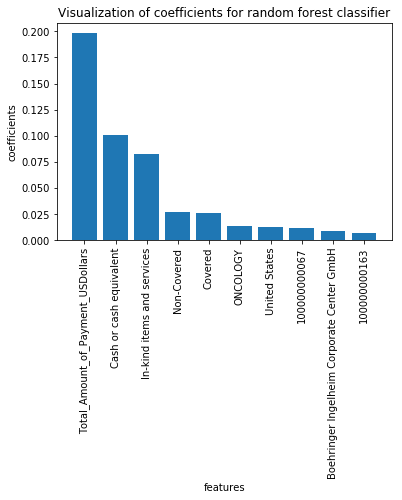

In [39]:
svc_df = get_model_df(gs_rf.best_estimator_,gs_rf.best_estimator_.named_steps['randomforestclassifier'].feature_importances_)
plt.xticks(rotation=90)
plt.bar(svc_df.iloc[:10,0],svc_df.iloc[:10,1])
plt.title("Visualization of coefficients for random forest classifier")
plt.xlabel("features")
plt.ylabel("coefficients")

### Run the model with best features

In [40]:
X_train_rf = pd.get_dummies(data=X_train,columns=['Recipient_State',
       'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Related_Product_Indicator', 'Covered_or_Noncovered_Indicator_1',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Product_Category_or_Therapeutic_Area_1',
       'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Associated_Drug_or_Biological_NDC_1',
       'Form_of_Payment_or_Transfer_of_Value'])

rf = RandomForestClassifier(n_estimators=430).fit(X_train_rf,y_train)
svc_df = pd.DataFrame({'cat':list(X_train_rf.columns),'coeff':rf.feature_importances_})
svc_df = svc_df.reindex(svc_df.coeff.abs().sort_values(ascending = False).index)
svc_df = svc_df.round(6)
cols_rem = list(svc_df[(svc_df['coeff']>=0) & (svc_df['coeff']<0.001)]['cat'])

X_train_new = X_train_rf.drop(cols_rem,axis=1)
param_rf = {'n_estimators': [300,350,400,430]}
gs_rf_new = GridSearchCV(estimator=RandomForestClassifier(),
                           param_grid=param_rf,scoring='roc_auc')
gs_rf_new.fit(X_train_new,y_train)
print(gs_rf_new.best_params_)
print(gs_rf_new.best_score_)

{'n_estimators': 400}
0.8550065540155453


I see that the score has dropped to 0.85 on removing very insignificant features whose importances ranged from 0 to 0.001.

### Task 6: An explainable model

Here we will use the features "Total_Amount_of_Payment_USDollars", "Form_of_Payment_or_Transfer_of_Value" and "Covered_Recipient_Type" and fit logistic regression. These are the features deemed highly informative both by visualization and by feature importances from random forest classifier output.

In [41]:
X_train, X_test, y_train_3 , y_test_3 = train_test_split(data.drop(labels = 'target', axis = 1),data['target'])

In [42]:
X_train_3 = pd.concat([X_train['Form_of_Payment_or_Transfer_of_Value'],X_train['Covered_or_Noncovered_Indicator_1'],X_train['Total_Amount_of_Payment_USDollars']],axis = 1)
X_test_3 =  pd.concat([X_test['Form_of_Payment_or_Transfer_of_Value'],X_test['Covered_or_Noncovered_Indicator_1'],X_test['Total_Amount_of_Payment_USDollars']],axis = 1)

In [43]:
data1 = X_train_3
data1_target = y_train_3

In [44]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

missing_values = dict(data1.isna().sum().sort_values(ascending=True))
for key,value in missing_values.items():
    if value !=0:
        
        target = key

        X_train1  = data1[pd.notnull(data1[target])]

        X_train1 = X_train1.replace(np.nan, 'empty', regex=True) #replace nans of categorical with emty

        y_train1 = X_train1[target].apply(list(set(list(X_train1[target]))).index)

        labels = np.asarray(list(set(list(X_train1[target]))))

        X_train1 = X_train1.drop(labels = target, axis = 1)
        y_train2 = data1_target[pd.notnull(data1[target])] #addition

        for name in list(X_train1):
            if name!="Total_Amount_of_Payment_USDollars":
                X_train1[name] = X_train1[name].astype(str)
        categorical = X_train1.dtypes == object

        y_train1 = y_train1.astype(int)
        preprocess = make_column_transformer(
        (StandardScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))
        model1 = make_pipeline(preprocess,KNeighborsClassifier(n_neighbors = 3 ))
        model1.fit(X_train1,y_train1)
        print("The model score for imputing",target ,"is",model1.score(X_train1,y_train1))


        #X_train1 is the null ones
        X_test1 =  data1[data1[target].isnull()]
        X_test1 = X_test1.replace(np.nan, 'empty', regex=True)
        X_test1 = X_test1.drop(labels = target, axis = 1)
        y_test1 = data1_target[data1[target].isnull()] #addition


        for name in list(X_test1):
            if name!="Total_Amount_of_Payment_USDollars":
                X_test1[name] = X_test1[name].astype(str)
        categorical = X_test1.dtypes == object
        


        X_test1[target] = labels[model1.predict(X_test1)]
        X_train1[target] = labels[y_train1]
        data1 = pd.concat([X_test1,X_train1])
        data1_target = pd.concat([y_test1,y_train2]) #addition
        data1=data1.replace('empty', np.nan)

The model score for imputing Covered_or_Noncovered_Indicator_1 is 0.8979509548770206


In [45]:
X_train_3 = data1
y_train_3 = data1_target

In [46]:
%%capture
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


    
for name in list(X_train_3):
    if name!="Total_Amount_of_Payment_USDollars":
        X_train_3[name] = X_train_3[name].astype(str)
categorical = X_train_3.dtypes == object


preprocess = make_column_transformer(
(StandardScaler(), ~categorical),
(OneHotEncoder(handle_unknown = 'ignore'), categorical))
model_logreg_3 = make_pipeline(preprocess,LogisticRegression())

scores = cross_val_score(model_logreg_3, X_train_3 , y_train_3, cv=3,scoring='roc_auc')

In [47]:
print(scores.mean())

0.9263457673272665


In [48]:
data1 = X_test_3
data1_target = y_test_3

In [49]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

missing_values = dict(data1.isna().sum().sort_values(ascending=True))
for key,value in missing_values.items():
    if value !=0:
        
        target = key

        X_train1  = data1[pd.notnull(data1[target])]

        X_train1 = X_train1.replace(np.nan, 'empty', regex=True) #replace nans of categorical with emty

        y_train1 = X_train1[target].apply(list(set(list(X_train1[target]))).index)

        labels = np.asarray(list(set(list(X_train1[target]))))

        X_train1 = X_train1.drop(labels = target, axis = 1)
        y_train2 = data1_target[pd.notnull(data1[target])] #addition

        for name in list(X_train1):
            if name!="Total_Amount_of_Payment_USDollars":
                X_train1[name] = X_train1[name].astype(str)
        categorical = X_train1.dtypes == object

        y_train1 = y_train1.astype(int)
        preprocess = make_column_transformer(
        (StandardScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))
        model1 = make_pipeline(preprocess,KNeighborsClassifier(n_neighbors = 3 ))
        model1.fit(X_train1,y_train1)
        print("The model score for imputing",target ,"is",model1.score(X_train1,y_train1))


        #X_train1 is the null ones
        X_test1 =  data1[data1[target].isnull()]
        X_test1 = X_test1.replace(np.nan, 'empty', regex=True)
        X_test1 = X_test1.drop(labels = target, axis = 1)
        y_test1 = data1_target[data1[target].isnull()] #addition


        for name in list(X_test1):
            if name!="Total_Amount_of_Payment_USDollars":
                X_test1[name] = X_test1[name].astype(str)
        categorical = X_test1.dtypes == object
        


        X_test1[target] = labels[model1.predict(X_test1)]
        X_train1[target] = labels[y_train1]
        data1 = pd.concat([X_test1,X_train1])
        data1_target = pd.concat([y_test1,y_train2]) #addition
        data1=data1.replace('empty', np.nan)

The model score for imputing Covered_or_Noncovered_Indicator_1 is 0.8922755281690141


In [50]:
X_test_3 = data1
y_test_3 = data1_target

In [51]:
pred = model_logreg_3.fit(X_train_3,y_train_3).predict(X_test_3)
roc_auc_score(y_test_3,pred)

0.8417396905108222

With 3 variables the score has decreased to 0.84 on test set.